Based on Retina net (https://arxiv.org/pdf/1708.02002.pdf) & FPN 

We are implementing RetinaNet paper to achieve higher accuracy in bounding box using FPN (Unet).

https://github.com/sgugger/Deep-Learning/blob/master/Retina%20net%20Pascal.ipynb

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Import libs

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from ipywidgets import FloatProgress
from IPython.display import display

Load pascal 2007 data

In [3]:
PATH = Path('data/pascal') # we have created simulink 
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [4]:
trn_json = json.load((PATH/'pascal_train2007.json').open())
cats = {o['id']:o['name'] for o in trn_json['categories']}
imgs_fn = {o['id']:o['file_name'] for o in trn_json['images']}
imgs_id = [o['id'] for o in trn_json['images']]

In [5]:
print("trn_json keys = {0} \n"
      "categories = {1} \n"
      "cats[1] = {2} \n"
      "imgs_fn (id:file_name) = {3}\n"
      "imgs_id (file_name:id) = {4}\n".format(trn_json.keys(), cats.keys(), cats[1], imgs_fn[12], imgs_id[12]))

trn_json keys = dict_keys(['images', 'type', 'annotations', 'categories']) 
categories = dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 
cats[1] = aeroplane 
imgs_fn (id:file_name) = 000012.jpg
imgs_id (file_name:id) = 48



In [5]:
trn_anno = collections.defaultdict(lambda:[])
for annot in trn_json['annotations']:
    if annot['ignore'] == 0:
        bb = annot['bbox']
        #Transforms bb which is left,top, width, height into top, left, bottom, right.
        bb = [bb[1],bb[0],bb[1] + bb[3], bb[0]+bb[2]]
        trn_anno[annot[('image_id')]].append((bb, annot['category_id']))
len(trn_anno)

2501

trn_anno = {image_id:[(bbox, category_id), (...)]}

Define arch

In [6]:
MBB_CSV = PATH/'tmp/mbb.csv'

f_model=resnet34
size=224
batch_size=32

In [7]:
annot_cats = [[cats[int(ann[1])] for ann in trn_anno[i]] for i in imgs_id]
id2cats = list(cats.values())
cats2id = {c:i for i,c in enumerate(id2cats)}
model_cats = np.array([np.array([cats2id[c] for c in ac]) for ac in annot_cats])

In [9]:
print("annot_cats[:5] = {0}\n"
      "id2cats[:5] = {1}\n"
      "cats2id[:5] = {2}\n"
      "model_cats = {3}".format(annot_cats[:5], id2cats[:5], "{'aeroplane': 0}",model_cats) )

annot_cats[:5] = [['car'], ['person', 'horse'], ['bicycle', 'bicycle', 'person', 'person', 'person'], ['car'], ['aeroplane', 'aeroplane', 'person', 'person']]
id2cats[:5] = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle']
cats2id[:5] = {'aeroplane': 0}
model_cats = [array([6]) array([14, 12]) array([ 1,  1, 14, 14, 14]) ... array([17,  8, 14, 14, 14]) array([6])
 array([11])]


In [8]:
val_idx = get_cv_idxs(len(imgs_id))
((val_cats, trn_cats),) = split_by_idx(val_idx, model_cats)

In [11]:
print("val_idx[:5] = {0}\n"
      "val_cats[:5]= {1}\n"
      "trn_cats[:5]= {2}\n".format(val_idx[:5], val_cats[:5],trn_cats[:5] )
)

val_idx[:5] = [1105 2055 1386 1036  321]
val_cats[:5]= [array([ 1, 14, 14]) array([11, 17]) array([2]) array([14]) array([14, 14, 14, 14, 14,  4,  4])]
trn_cats[:5]= [array([6]) array([14, 12]) array([ 1,  1, 14, 14, 14]) array([6]) array([ 0,  0, 14, 14])]



In [9]:
model_bbs = [np.concatenate([ann[0] for ann in trn_anno[i]]) for i in imgs_id]
model_bbsc = [' '.join([str(p) for p in o]) for o in model_bbs]

In [13]:
print("\033[1m model_bbs[:5] \033[0m = {0}\n"
      "\033[1m model_bbsc[:5] \033[0m = {1}\n".format(model_bbs[:5], model_bbsc[:5])
)

 model_bbs[:5]  = [array([ 96, 155, 270, 351]), array([ 61, 184, 199, 279,  77,  89, 336, 403]), array([229,   8, 500, 245, 219, 229, 500, 334,   0,   1, 369, 117,   1,   2, 462, 243,   0, 224, 486, 334]), array([124,  89, 212, 337]), array([ 77, 103, 183, 375,  87, 132, 123, 197, 179, 194, 229, 213, 188,  25, 238,  44])]
 model_bbsc[:5]  = ['96 155 270 351', '61 184 199 279 77 89 336 403', '229 8 500 245 219 229 500 334 0 1 369 117 1 2 462 243 0 224 486 334', '124 89 212 337', '77 103 183 375 87 132 123 197 179 194 229 213 188 25 238 44']



In [10]:
df = pd.DataFrame({'fn': [imgs_fn[i] for i in imgs_id], 'bbs': model_bbsc},columns=['fn','bbs'])
df.to_csv(MBB_CSV, index=False)
df.head()

,fn,bbs
0,000012.jpg,96 155 270 351
1,000017.jpg,61 184 199 279 77 89 336 403
2,000023.jpg,229 8 500 245 219 229 500 334 0 1 369 117 1 2 ...
3,000026.jpg,124 89 212 337
4,000032.jpg,77 103 183 375 87 132 123 197 179 194 229 213 ...


### Create Model, Dataset

TfmType.COORD is used to add co-ordinate transformation

In [11]:
aug_tfms = [RandomRotate(10, tfm_y = TfmType.COORD),
           RandomLighting(0.05,0.05, tfm_y = TfmType.COORD),
           RandomFlip(tfm_y = TfmType.COORD)]
tfms = tfms_from_model(f_model, size, aug_tfms=aug_tfms, crop_type=CropType.NO, tfm_y = TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4, val_idxs=val_idx, bs=batch_size)

In [12]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [13]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_cats)
val_ds2 = ConcatLblDataset(md.val_ds, val_cats)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [14]:
n_clas = 20
k=9 

#### We will use resnet34. 

In [15]:
f = resnet34
cut,lr_cut = model_meta[f]
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

This will allow us to save some intermerdiary features when calling the resnet model on an input. We need the last result of the resnet, called c5 in the paper, as well as the ouputs of the two previous groups of layers (c4 and c3).

Same as before, flattens the output of our final convolutional layers that predict boxes/classes. Their size is mb by n by h by w (mb = minibatch, n = k times 20 or 4, h = height, w = width). We want the a tensor of size mb by a by 20/4 where a is the total number of anchors of this layer ($a = h \times w \times k$) so we put the seond dimension at the end before resizing.

In [16]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

Head of the network, takes one level of the FPN and predict class/boxes predictions for each anchor of this level.

<img src="https://github.com/nik-hil/ai-noteook/blob/master/image/retinanet.png?raw=true">


From the paper:

Taking an input feature map with C channels from a given pyramid level, the subnet applies four 3×3 conv layers, each with C filters and each followed by ReLU activations, followed by a 3×3 conv layer with KA filters.
RetinaHead implements those four convolutional layers as well as the two last ones. C = 256, A is our k (9) and K is either the number of classes or 4. We don't include the sigmoid on the activation for the categories as it will be done in the loss function (with the pytoch function BCE with logits).

The bias comes from their idea in terms of initialization:

All new conv layers except the final one in the RetinaNet subnets are initialized with bias b = 0 and a Gaussian weight fill with σ = 0.01. For the final conv layer of the classification subnet, we set the bias initialization to b = −log((1 − π)/π), where π specifies that at the start of training every anchor should be labeled as foreground with confidence of ∼π. We use π = .01 in all ex- periments, although results are robust to the exact value.
This is to make it easy for the network to predict background.

In [17]:
class RetinaHead(nn.Module):
    def __init__(self, bias, k):
        super().__init__()
        self.k = k
        self.conv_cls = nn.ModuleList([nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)] * 4)
        self.conv_box = nn.ModuleList([nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)] * 4)
        self.out_cls = nn.Conv2d(256,n_clas * k,kernel_size=3,stride=1,padding=1)
        self.out_box = nn.Conv2d(256, 4 * k,kernel_size=3,stride=1,padding=1)
        self.out_cls.bias.data.zero_().add_(bias)
        
    def forward(self,x):
        y = x.clone()
        for i in range(len(self.conv_cls)):
            x = F.relu(self.conv_cls[i](x))
            y = F.relu(self.conv_box[i](y))
        return [flatten_conv(self.out_cls(x), self.k),
                flatten_conv(self.out_box(y), self.k)]

In [18]:
class RetinaNet(nn.Module):
    def __init__(self, rn, k, bias):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [5,6]]
        end_ch = 512 #would be 2048 in Resnet50
        self.top1 = nn.Conv2d(end_ch,256,kernel_size=3,stride=2,padding=1) #512 would be 2048 in Resnet50
        self.top2 = nn.Conv2d(256,256,kernel_size=3,stride=2,padding=1)
        self.lat1 = nn.Conv2d(end_ch,256,kernel_size=1)
        self.lat2 = nn.Conv2d(end_ch//2,256,kernel_size=1)
        self.lat3 = nn.Conv2d(end_ch//4,256,kernel_size=1)
        self.down1 = nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)
        self.down2 = nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)
        self.head = RetinaHead(bias, k)
        
    def forward(self, x):
        c5 = F.relu(self.rn(x))
        p5 = self.lat1(c5)
        p4 = self.down1(self.up_add(p5,self.lat2(self.sfs[1].features)))
        p3 = self.down2(self.up_add(p4, self.lat3(self.sfs[0].features)))
        p6 = self.top1(c5)
        p7 = self.top2(F.relu(p6))
        out_cls, out_box = [], []
        for p in [p3,p4,p5,p6,p7]:
            oc, ob = self.head(p)
            out_cls.append(oc)
            out_box.append(ob)
        return [torch.cat(out_cls, dim=1),
                torch.cat(out_box, dim=1)]
    
    def up_add(self,x,y):
        _,_,h,w = y.size()#//we want x to have y size.
        return F.upsample(x, size=(h,w), mode='nearest') + y

In [19]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

Anchors
With an initial size of 224, features P3 to P7 have a size of 28 by 28, 14 by 14, 7 by 7, 4 by 4 and 2 by 2 respectively.

As in [20], at each pyramid level we use anchors at three aspect ratios {1:2, 1:1, 2:1}. For denser scale coverage than in [20], at each level we add anchors of sizes {2^0, 2^1/3, 2^2/3} of the original set of 3 aspect ratio anchors. This improve AP in our setting. In total there are A = 9 anchors.

In [20]:
anc_grids = [28,14,7,4,2] #Depends of the initial size 224.
anc_zooms = [1., 2**(1/3), 2**(2/3)]
anc_ratios = [(1.,1.), (1.,2), (2,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
anc_offsets = [1/(o*2) for o in anc_grids]

In [21]:
k, len(anchor_scales)

(9, 9)

In [22]:
anc_x = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [27]:
anc_x, anc_y, anc_ctrs

(array([0.01786, 0.05357, 0.08929, ..., 0.75   , 0.25   , 0.75   ]),
 array([0.01786, 0.01786, 0.01786, ..., 0.25   , 0.75   , 0.75   ]),
 array([[0.01786, 0.01786],
        [0.01786, 0.01786],
        [0.01786, 0.01786],
        ...,
        [0.75   , 0.75   ],
        [0.75   , 0.75   ],
        [0.75   , 0.75   ]]))

In [23]:
def hw2corners(ctr, hw): 
    # height weight to corner
    return torch.cat([ctr-hw/2,ctr+hw/2], dim=1)

In [24]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [30]:
print("\033[1m anc_sizes[:3] \033[0m  = {0}\n" 
      "\033[1m grid_sizes[:3] \033[0m = {1}\n"
      "\033[1m anchors[:3]  \033[0m   = {2}\n"
      "\033[1m anchor_cnr[:3] \033[0m = {3}".format(anc_sizes[:3], grid_sizes[:3], anchors[:3], anchor_cnr[:3])
)

 anc_sizes[:3]   = [[0.03571 0.03571]
 [0.03571 0.07143]
 [0.07143 0.03571]]
 grid_sizes[:3]  = Variable containing:
1.00000e-02 *
  3.5714
  3.5714
  3.5714
[torch.cuda.FloatTensor of size 3x1 (GPU 0)]

 anchors[:3]     = Variable containing:
1.00000e-02 *
  1.7857  1.7857  3.5714  3.5714
  1.7857  1.7857  3.5714  7.1429
  1.7857  1.7857  7.1429  3.5714
[torch.cuda.FloatTensor of size 3x4 (GPU 0)]

 anchor_cnr[:3]  = Variable containing:
1.00000e-02 *
  0.0000  0.0000  3.5714  3.5714
  0.0000 -1.7857  3.5714  5.3571
 -1.7857  0.0000  5.3571  3.5714
[torch.cuda.FloatTensor of size 3x4 (GPU 0)]



In [31]:
print("Total boxes {0}".format(anchors.size()))

Total boxes torch.Size([9441, 4])


Matching and Focal loss

No change from the Pascal notebook apart from one:

The total focal loss of an image is computed as the sum of the focal loss over all ∼100k anchors, normalized by the number of anchors assigned to a ground-truth box.
(They have 100K anchors because their initial resolution is higher than 224.)

#### Focal loss add very less weight to well classified examples and large weight to miss-classified or hard classified examples.
<img src="https://github.com/nik-hil/ai-noteook/blob/master/image/focallos.png?raw=true">

In [25]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class Focal_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
    
    def forward(self, preds, targets):
        t = one_hot_embedding(targets, self.num_classes+1)
        t = V(t[:,:-1].contiguous()) #bg class is predicted when none of the others go out.
        w = self.get_weight(preds,t)
        return F.binary_cross_entropy_with_logits(preds, t, w, size_average=False) / self.num_classes
    
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = Focal_Loss(len(id2cats))

def intersection(box_a,box_b):
    min_xy = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    max_xy = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp(max_xy-min_xy,min=0)
    return inter[:,:,0] * inter[:,:,1]

def get_size(box):
    return (box[:,2]-box[:,0]) * (box[:,3] - box[:,1])

def jaccard(box_a,box_b):
    inter = intersection(box_a,box_b)
    union = get_size(box_a).unsqueeze(1) + get_size(box_b).unsqueeze(0) - inter
    return inter/union

#Removes the zero padding in the target bbox/class
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/size
    bb_keep = ((bbox[:,2] - bbox[:,0])>0.).nonzero()[:,0]
    return bbox[bb_keep], clas[bb_keep]
    
def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_ctrs = (actn_bbs[:,:2] * grid_sizes/2) + anchors[:,:2]
    actn_hw = (1 + actn_bbs[:,2:]/2) * anchors[:,2:]
    return hw2corners(actn_ctrs,actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False, use_ab=True):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, (anchor_cnr if use_ab else a_ic).data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.5
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cats)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas) / len(pos_idx) #Normalized by the number of anchors matched to a GT object
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

def ssd_loss2(pred,targ):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,use_ab=False)
        lls += loc_loss
        lcs += clas_loss
    return lls+lcs

## Training

In [26]:
pi = 0.01
init_b = - np.log((1-pi)/pi)
init_b

-4.59511985013459

In [27]:
m_base = get_base()
m = to_gpu(RetinaNet(m_base,k,init_b))
models = UpsampleModel(m)

In [35]:
models.model

RetinaNet(
  (rn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1),

In [28]:
learn = ConvLearner(md, models)
learn.opt_fn=partial(optim.SGD,momentum=0.9)
learn.crit = ssd_loss

In [37]:
learn.lr_find()

 75%|███████▍  | 47/63 [00:51<00:17,  1.11s/it, loss=5.2] 

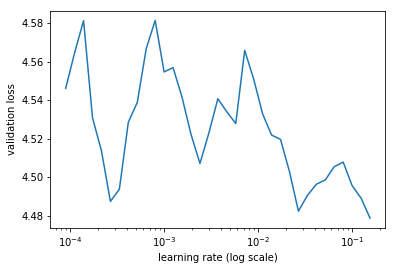

In [38]:
learn.sched.plot(10,1)

In [39]:
learn.fit(1e-3,1,cycle_len=5, )#use_clr_beta=(5,5,0.95,0.85)

epoch      trn_loss   val_loss                             
    0      4.518554   4.299646  
    1      4.3837     4.132306                             
    2      4.252968   4.041772                             
    3      4.19151    4.015882                             
    4      4.147303   4.001316                             


[array([4.00132])]

In [40]:
learn.fit(1e-2,1,cycle_len=1,use_clr_beta=(20,10))

epoch      trn_loss   val_loss                             
    0      3.677338   3.469529  


[array([3.46953])]

In [41]:
learn.fit(1e-2,1,cycle_len=1,use_clr_beta=(20,10))

epoch      trn_loss   val_loss                             
    0      3.400428   3.385203  


[array([3.3852])]

In [42]:
learn.fit(1e-2,1,cycle_len=1,use_clr_beta=(20,10))

epoch      trn_loss   val_loss                             
    0      3.169378   3.092442  


[array([3.09244])]

In [43]:
learn.fit(1e-2,1,cycle_len=2,use_clr_beta=(20,10))

epoch      trn_loss   val_loss                             
    0      3.076388   3.156566  
    1      2.997953   3.005081                             


[array([3.00508])]

In [44]:
learn.fit(1e-2,1,cycle_len=2,use_clr_beta=(20,10))

epoch      trn_loss   val_loss                             
    0      3.029456   3.271323  
    1      3.036894   3.0686                               


[array([3.0686])]

In [45]:
learn.save('retina-net.3-0686')

In [29]:
learn.load('retina-net.3-0686')

In [30]:
learn.fit(1e-2,1,cycle_len=2,use_clr_beta=(20,10))

epoch      trn_loss   val_loss                             
    0      2.992767   3.102808  
    1      2.927455   2.961133                             



[array([2.96113])]

In [31]:
learn.save('retina-net.3-0686')

In [32]:
learn.fit(1e-2,1,cycle_len=2,use_clr_beta=(20,10))

epoch      trn_loss   val_loss                             
    0      2.875598   3.198049  
    1      2.852963   2.928189                             



[array([2.92819])]

In [33]:
learn.save('retina-net.3-0686')

In [34]:
learn.load('retina-net.3-0686')

In [35]:
lr = 4e-2
lrs = np.array([lr/100,lr/10,lr])
learn.unfreeze()

In [36]:
learn.lr_find(start_lr = lrs/1000, end_lr = lrs*10)


 92%|█████████▏| 58/63 [01:17<00:06,  1.33s/it, loss=5.47]

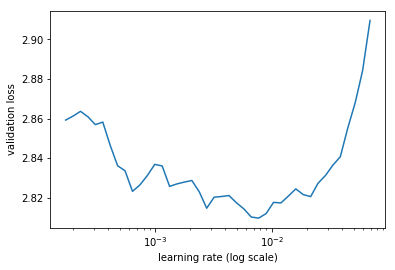

In [39]:
learn.sched.plot()

In [40]:
lr = 8e-3
lrs = np.array([lr/100,lr/10,lr])
learn.fit(lrs,1,cycle_len=20, use_clr_beta=(10,10,0.95,0.85))

epoch      trn_loss   val_loss                             
    0      2.776856   2.909762  
    1      2.764953   2.904691                             
    2      2.760954   2.898853                             
    3      2.734637   2.88248                              
    4      2.711626   2.859602                             
    5      2.667579   2.771557                             
    6      2.606555   2.772563                             
    7      2.544449   2.754621                             
    8      2.498359   2.731815                             
    9      2.453953   2.678473                             
    10     2.399343   2.63069                              
    11     2.370941   2.635411                             
    12     2.338868   2.629427                             
    13     2.280398   2.614421                             
    14     2.239778   2.561854                             
    15     2.207591   2.539703                             
    16 

[array([2.48186])]

In [41]:
learn.save('retina-net.2.48186')

## NMS

We use NMS to suppress low confident bbox.

In [42]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

## Few plots

In [43]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def bb_to_hw(bb):
    return [bb[1],bb[0],bb[3]-bb[1], bb[2]-bb[0]]

def show_img(im, figsize=None, axis=None):
    if not axis:
        fig,axis = plt.subplots(figsize=figsize)
    axis.imshow(im)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    return axis

def draw_outline(obj,lw):
    obj.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(axis, box, color='white'):
    patch = axis.add_patch(patches.Rectangle(box[:2],box[-2],box[-1],fill=False,edgecolor=color,lw=2))
    draw_outline(patch,4)
    
def draw_text(axis,xy,text,text_size=14, color='white'):
    patch = axis.text(*xy, text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
    draw_outline(patch,1)
    
def show_img_all(id_img):
    img = open_image(IMG_PATH/imgs_fn[id_img])
    axis = show_img(img, figsize=(16,8))
    for bbox, id_cat in trn_anno[id_img]:
        new_box = bb_to_hw(bbox)
        draw_rect(axis, new_box)
        draw_text(axis, new_box[:2], cats[id_cat])
        
def show_ground_truth(ax, im, bbox, clas = None, prs = None, tresh = 0.3):
    bb = [bb_to_hw(o) for o in bbox.reshape(-1,4)]
    if clas is None: clas = [None] * len(bb)
    if prs is None: prs = [None] * len(bb)
    ax = show_img(im,axis=ax)
    for i, (b,c,pr) in enumerate(zip(bb,clas,prs)):
        if b[2] > 0 and (pr is None or pr > tresh):#Show the bow only if there is something to show
            draw_rect(ax, b, colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c == len(id2cats) else id2cats[c])
            if pr is not None: txt += f'{pr:.2f}'
            draw_text(ax,b[:2],txt,color=colr_list[i%num_colr])
        
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

def np_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, (bbox*224).astype(np.uint8),
         clas, prs if prs is not None else None, thresh)

In [44]:
learn.load('retina-net.2.48186')
learn.model.eval()
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
pred = learn.model(x)

In [46]:
def get1preds(b_clas,b_bb,bbox,clas,thresh=0.25):
    bbox,clas = get_y(bbox, clas)
    a_ic = actn_to_bb(b_bb, anchors)
    clas_pr, clas_ids = b_clas.max(1)
    conf_scores = b_clas.sigmoid().t().data
    out1,out2,cc = [],[],[]
    for cl in range(conf_scores.size(0)-1):
        cl_mask = conf_scores[cl] > thresh
        if cl_mask.sum() == 0: continue
        scores = conf_scores[cl][cl_mask]
        l_mask = cl_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    cc = T(np.concatenate(cc)) if cc != [] else None
    out1 = torch.cat(out1) if out1 != [] else None
    out2 = torch.cat(out2) if out2 != [] else None
    return out1,out2,cc

def show_results(idx, thresh=0.25, ax=None):
    if ax is None: fig, ax = plt.subplots(figsize=(6,6))
    ima=md.val_ds.ds.denorm(x)[idx]
    out1,out2,cc = get1preds(pred[0][idx],pred[1][idx],y[0][idx],y[1][idx],thresh)
    torch_gt(ax, ima, out2, cc, out1, 0.1)
    
def show_gt(idx, ax=None):
    if ax is None: fig, ax = plt.subplots(figsize=(6,6))
    ima = md.val_ds.ds.denorm(x)[idx]
    show_ground_truth(ax,ima,to_np(y[0][idx]),to_np(y[1][idx]))
    
def compare(idx,thresh=0.25):
    fig, axs = plt.subplots(1,2,figsize=(12,6))
    show_results(idx,thresh,ax=axs[0])
    show_gt(idx,ax=axs[1])
    plt.tight_layout()

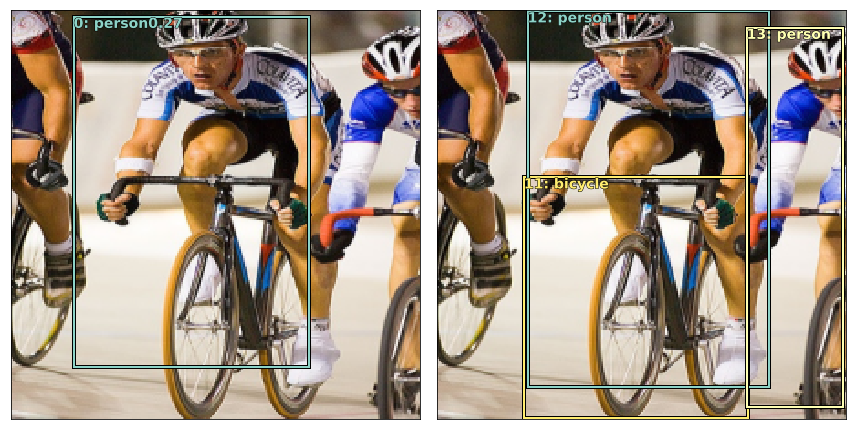

In [47]:
compare(0)

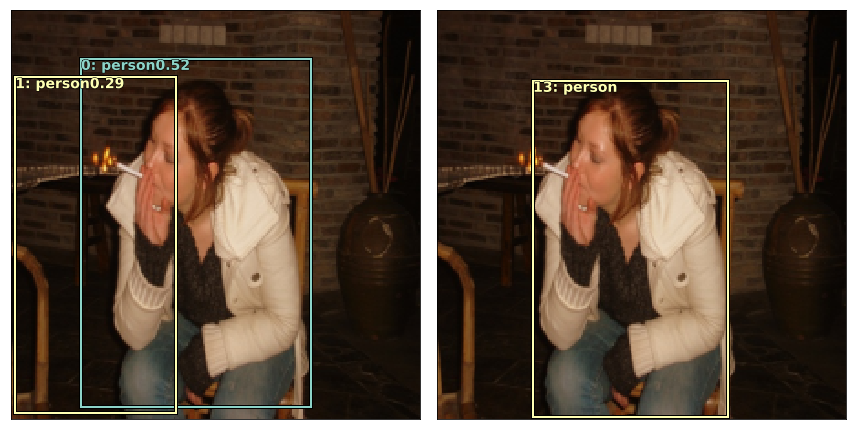

In [50]:
compare(3)

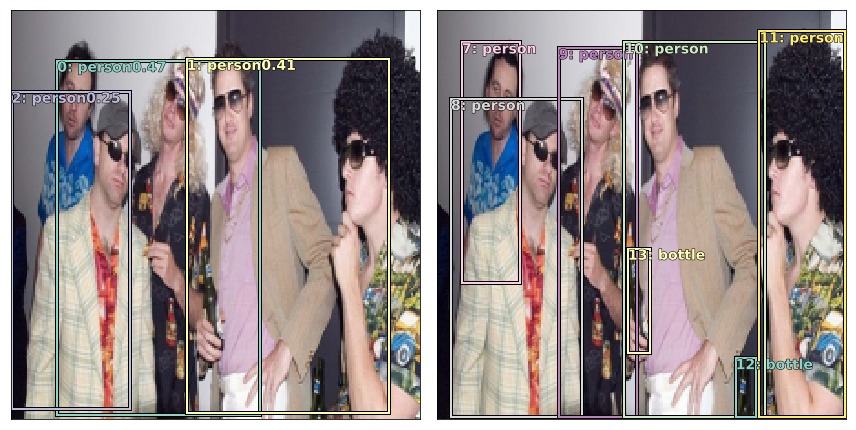

In [51]:
compare(4)

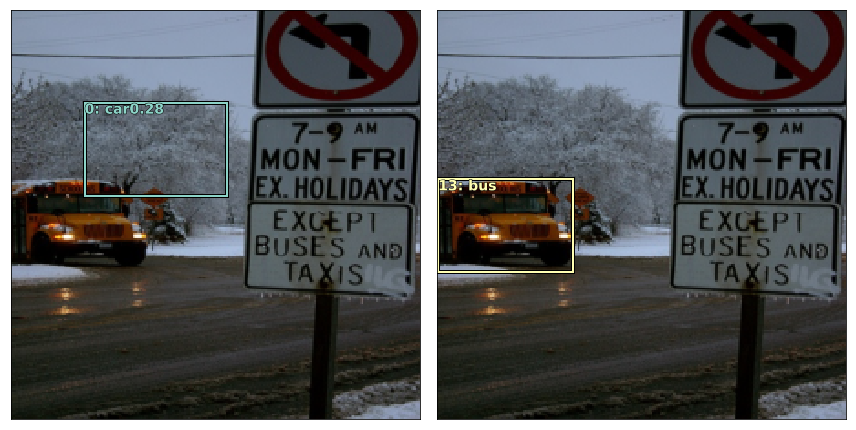

In [52]:
compare(5)

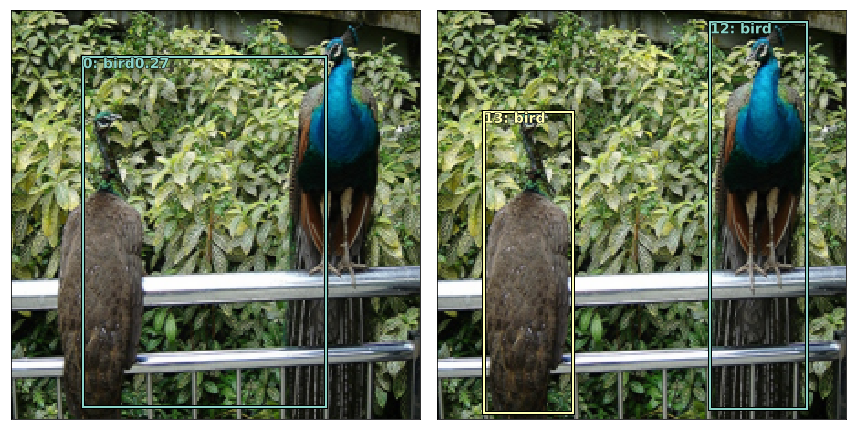

In [55]:
compare(8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


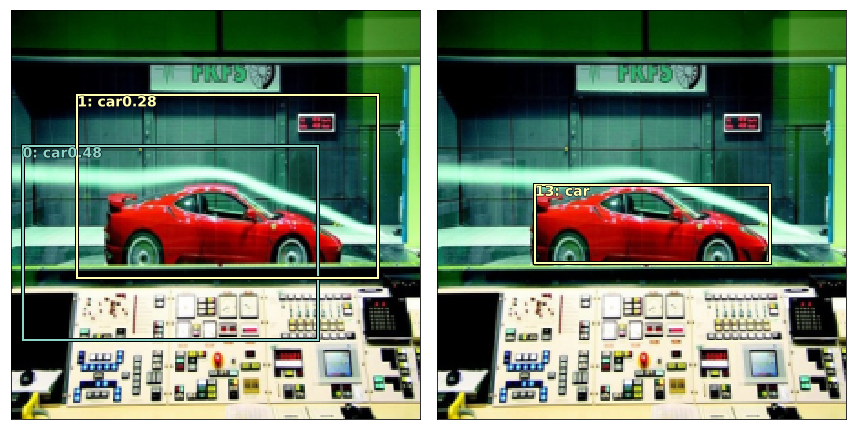

In [58]:
compare(11)

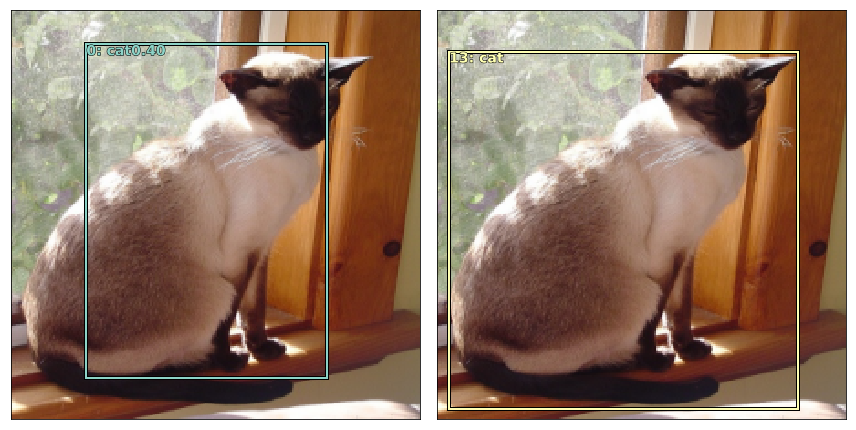

In [60]:
compare(13)

In [61]:
def count(L):
    result = collections.defaultdict(int)
    if L is not None:
        for x in L:
            result[x] += 1
    return result

from ipywidgets import FloatProgress
from IPython.display import display
def multiTPFPFN():
    n = 40
    threshes = np.linspace(.05, 0.95, n, endpoint=True)
    tps,fps,fns = np.zeros((n,len(id2cats))),np.zeros((n,len(id2cats))),np.zeros((n,len(id2cats)))
    prog = FloatProgress(min=0,max=len(md.val_dl))
    display(prog)
    for data in md.val_dl:
        x,y = data
        x,y = V(x),V(y)
        pred = learn.model(x)
        for idx in range(x.size(0)):
            bbox,clas = get_y(y[0][idx],y[1][idx])#unpad the target
            p_scrs,p_box,p_cls = get1preds(pred[0][idx],pred[1][idx],y[0][idx],y[1][idx],threshes[0])
            overlaps = to_np(jaccard(p_box,bbox.data))
            overlaps = np.where(overlaps > 0.5, overlaps, 0)
            clas, np_scrs, np_cls = to_np(clas.data),to_np(p_scrs), to_np(p_cls)
            for k in range(threshes.shape[0]):
                new_tp = collections.defaultdict(int)
                for cls in list(set(clas)):
                    msk_clas = np.bitwise_and((clas == cls)[None,:],(np_cls == cls)[:,None])
                    ov_clas = np.where(msk_clas,overlaps,0.)
                    mx_idx = np.argmax(ov_clas,axis=1)
                    for i in range(0,len(clas)):
                        if (clas[i] == cls):
                            keep = np.bitwise_and(np.max(ov_clas,axis=1) > 0.,mx_idx==i)
                            keep = np.bitwise_and(keep,np_scrs > threshes[k])
                            if keep.sum() > 0:
                                new_tp[cls] += 1
                count_pred = count(np_cls[np_scrs > threshes[k]])
                count_gt = count(clas)
                for c in range(len(id2cats)):
                    tps[k,c] += new_tp[c]
                    fps[k,c] += count_pred[c] - new_tp[c]
                    fns[k,c] += count_gt[c] - new_tp[c]
        prog.value += 1 
    return tps, fps, fns

tps, fps, fns = multiTPFPFN()

FloatProgress(value=0.0, max=16.0)

In [62]:
def avg_prec(clas):
    eps = 1e-15
    precisions = tps[:,clas]/(tps[:,clas] + fps[:,clas] + eps)
    recalls = tps[:,clas]/(tps[:,clas] + fns[:,clas] + eps)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    return np.array(prec_at_rec).mean()

In [63]:
def mAP():
    S = 0
    for i in range(len(id2cats)):
        S += avg_prec(i)
    return S/len(id2cats)

In [64]:
mAP()

0.13058341172862595